In [1]:
import collections
from collections import OrderedDict
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import json
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
import itertools

import folium
import shapely.affinity
from shapely.geometry import Point, Polygon, LineString
import geopy
import geopy.distance
from scipy.interpolate import interp1d

# from geoplot import kdeplot
import seaborn as sns

import kml2geojson as k2g
import xmltodict

from astropy import units as u
from astropy.units import cds
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.coordinates import get_sun, get_body

from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from tqdm import tqdm

from street_sunset_finder import StreetSunsetFinder

import numpy as np
from astropy import units as u
from astropy.units import cds
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.coordinates import get_sun, get_body
import matplotlib.pyplot as plt
from matplotlib import animation

In [2]:
def sinuosity(geom):
    if geom.geom_type == 'MultiLineString':
        return 9999.
    assert geom.geom_type == "LineString", geom.geom_type
    length = geom.length
    start_pt = geom.interpolate(0)
    end_pt = geom.interpolate(1, normalized=True)
    straight_dist = start_pt.distance(end_pt)
    if straight_dist == 0.0:
        if length == 0.0:
            return 0.0
        return 9999.
    return length / straight_dist

In [3]:
shp_path = 'voie/voie.shp'
# shp_path = 'dcm_20250630shp/DCM_ArterialsMajorStreets.shp'
roads_full = gpd.GeoDataFrame.from_file(shp_path, encoding='utf-8')
roads_full.head()

,n_sq_vo,c_coinsee,c_desi,c_liaison,l_voie,l_courtmin,l_longmin,c_voie,b_fantoir,b_off,c_voie_vp,objectid,c_domoff,n_sq_co,length,geometry
0,750003643,75056,AV,DU,DOCTEUR GLEY,Av. du Docteur Gley,Avenue du Docteur Gley,750562834,O,O,2854,6591,P,750001537,None,"LINESTRING (2.40955 48.87791, 2.40987 48.87740..."
1,750001741,75056,SQ,None,CLAUDE DEBUSSY,Sq. Claude Debussy,Square Claude Debussy,750562074,O,O,2083,6598,O,750001537,None,"LINESTRING (2.31407 48.88406, 2.31315 48.88474)"
2,750001742,75056,RUE,None,CLAUDE GARAMOND,R. Claude Garamond,Rue Claude Garamond,750562075,O,O,2079,6599,P,750001537,None,"LINESTRING (2.30024 48.82585, 2.30050 48.82581..."
3,750003800,75056,RUE,None,CHARLES NODIER,R. Charles Nodier,Rue Charles Nodier,750561866,O,O,1869,6715,P,750001537,None,"LINESTRING (2.34483 48.88445, 2.34487 48.88482..."
4,750001798,75056,AV,DES,CHASSEURS,Av. des Chasseurs,Avenue des Chasseurs,750561910,O,O,1905,6730,P,750001537,None,"LINESTRING (2.30643 48.88741, 2.30614 48.88719..."


In [22]:
roads_full['Route_Name'] = roads_full['l_longmin']

In [4]:
roads_full.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

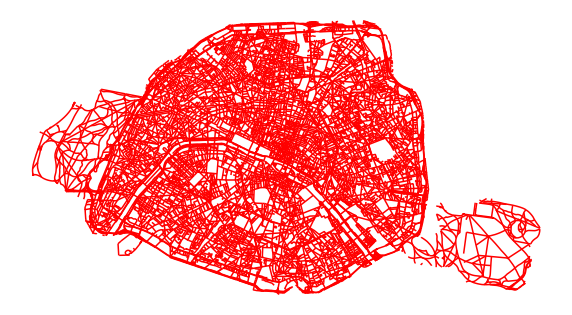

In [5]:
import matplotlib.colors as cm
f, ax = plt.subplots(1, figsize=(10, 10))

roads_full.plot(ax=ax, linewidth=1.5, color='red', zorder=1)
plt.axis('off')
# 
# plt.savefig(f'{town_name}_1.png', bbox_inches='tight', dpi=320)
# plt.xlim(-74.05, -73.90)
# plt.ylim(40.70, 40.85)
plt.show()

In [6]:
roads = roads_full

In [7]:
roads['sinuosity'] = list(roads.geometry.apply(lambda x: sinuosity(x)).copy())

In [8]:
roads['azimuth'] = list(roads.to_crs(4326).geometry.apply(lambda x: StreetSunsetFinder(latitude=0., longitude=0.).calculate_street_azimuth(x)))

In [240]:
# roads.to_crs(4326)

In [9]:
def convert_azimuth(x):
    if x < 180:
        return 180 + x
    else:
        return x
    
roads.azimuth = roads.azimuth.apply(lambda x: convert_azimuth(x))

In [10]:
roads.to_crs(4326).bounds
city_center = [(roads.to_crs(4326).bounds.minx.min() + roads.to_crs(4326).bounds.maxx.max()) / 2, (roads.to_crs(4326).bounds.miny.min() + roads.to_crs(4326).bounds.maxy.max()) / 2]
city_center

[2.3479608024969147, 48.85885355467761]

In [11]:
loc1 = EarthLocation(lat=city_center[1]*u.deg, lon=city_center[0]*u.deg, height=0*u.m)
name_loc1 = 'Paris'

In [12]:
from astroplan import Observer
from datetime import tzinfo, timezone

In [13]:
apo = Observer(location=loc1)
time = Time('2025-08-14 00:05:06')
sun_set = apo.sun_set_time(time, which="next") 

In [15]:
sun_set.to_datetime(timezone=timezone(timedelta(hours=+1), 'UTC'))

datetime.datetime(2025, 8, 14, 20, 2, 1, 303453, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600), 'UTC'))

In [16]:
az = apo.sun_altaz(time=sun_set).az.to(u.deg)

In [17]:
az.value

291.72873446929555

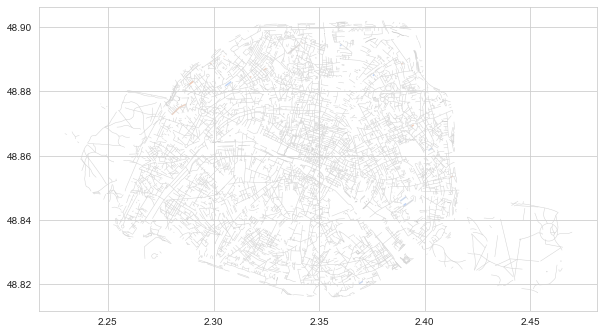

In [32]:
import matplotlib.colors as cm
f, ax = plt.subplots(1, figsize=(10, 10))

roads_valid = roads.loc[(np.abs(roads.azimuth - az.value) < 0.25)&(roads.sinuosity < 100)]
roads_invalid = roads.loc[np.abs(roads.azimuth - az.value) > 1]
roads_valid.geometry.to_crs(4326).plot(ax=ax, linewidth=1.5, color=plt.get_cmap('coolwarm')(cm.Normalize(-1, 1)((az.value - roads_valid.azimuth))), zorder=1)
roads_invalid.geometry.to_crs(4326).plot(ax=ax, linewidth=0.5, color='lightgrey', zorder=1)
# roads.loc[np.abs(roads.azimuth - 300) < 1].geometry.to_crs(4326).plot(ax=ax, linewidth=1.5, color=plt.get_cmap('viridis')(cm.Normalize(0, 1)(np.abs(az.value - roads.azimuth))), zorder=1)
# roads.loc[roads.geometry.apply(lambda x: isinstance(x, shapely.geometry.linestring.LineString))].to_crs(4326).iloc[18:19].plot(ax=ax, linewidth=0.5, color='lightgrey', zorder=1)
# town.loc[town.flag_visited != 0].plot(ax=ax, linewidth=0.5, color='lavender', alpha=0.8, zorder=2)

# dots = ax.scatter(df_town['longitude'], df_town['latitude'], c=cmap_solar([get_sun_alt(date, t, loc=city_dict[town_name]['center']) for date, t in zip(df_town['date'], df_town['time'])]),
#                   s=7., vmin=0, vmax=24., alpha=0.8, zorder=3)
# plt.axis('off')
# 
# plt.savefig(f'{town_name}_1.png', bbox_inches='tight', dpi=320)
# plt.xlim(-74.05, -73.90)
# plt.ylim(40.70, 40.85)
plt.show()

In [33]:
from datetime import date, timedelta

def daterange(start_date: date, end_date: date):
    days = int((end_date - start_date).days)
    for n in range(days):
        yield start_date + timedelta(n)

start_date = date(2025, 1, 1)
end_date = date(2025, 12, 31)
henge_time = dict()
valid_dates = set()
for single_date in daterange(start_date, end_date):
    time = Time(single_date.strftime("%Y-%m-%d") + ' 00:00:00')
    sun_set = apo.sun_set_time(time, which="next")
    try:
        az = apo.sun_altaz(time=sun_set).az.to(u.deg)
    except:
        continue
    for rd in roads.iterrows():
        if np.abs(rd[1].azimuth - az.value) < 0.25:
            valid_dates.add(single_date.strftime("%Y-%m-%d"))
            # print(single_date.strftime("%Y-%m-%d"), rd[1].Route_Name)
            if rd[1].Route_Name in henge_time:
                henge_time.get(rd[1].Route_Name).append(sun_set.to_datetime(timezone=timezone(timedelta(hours=+1), 'UTC')).strftime(format='%Y-%m-%dT%H:%M:%S'))
            else:
                henge_time[rd[1].Route_Name] = [sun_set.to_datetime(timezone=timezone(timedelta(hours=+1), 'UTC')).strftime(format='%Y-%m-%dT%H:%M:%S')]

In [34]:
roads['henge_time'] = roads['Route_Name'].map(henge_time)

In [35]:
roads.loc[roads.sinuosity < 1.2].to_csv('processed_Paris_roads.csv', index=False)

In [37]:
np.save('Paris_valid_dates.npy', np.array(list(valid_dates)))

In [38]:
roads

,n_sq_vo,c_coinsee,c_desi,c_liaison,l_voie,l_courtmin,l_longmin,c_voie,b_fantoir,b_off,c_voie_vp,objectid,c_domoff,n_sq_co,length,geometry,sinuosity,azimuth,Route_Name,henge_time
0,750003643,75056,AV,DU,DOCTEUR GLEY,Av. du Docteur Gley,Avenue du Docteur Gley,750562834,O,O,2854,6591,P,750001537,None,"LINESTRING (2.40955 48.87791, 2.40987 48.87740...",1.054486,303.625901,Avenue du Docteur Gley,"[2025-05-26T20:33:34, 2025-05-27T20:34:40, 202..."
1,750001741,75056,SQ,None,CLAUDE DEBUSSY,Sq. Claude Debussy,Square Claude Debussy,750562074,O,O,2083,6598,O,750001537,None,"LINESTRING (2.31407 48.88406, 2.31315 48.88474)",1.000000,318.370975,Square Claude Debussy,NaN
2,750001742,75056,RUE,None,CLAUDE GARAMOND,R. Claude Garamond,Rue Claude Garamond,750562075,O,O,2079,6599,P,750001537,None,"LINESTRING (2.30024 48.82585, 2.30050 48.82581...",1.000971,286.488719,Rue Claude Garamond,"[2025-04-17T19:40:16, 2025-08-24T19:43:21]"
3,750003800,75056,RUE,None,CHARLES NODIER,R. Charles Nodier,Rue Charles Nodier,750561866,O,O,1869,6715,P,750001537,None,"LINESTRING (2.34483 48.88445, 2.34487 48.88482...",1.000246,184.762964,Rue Charles Nodier,NaN
4,750001798,75056,AV,DES,CHASSEURS,Av. des Chasseurs,Avenue des Chasseurs,750561910,O,O,1905,6730,P,750001537,None,"LINESTRING (2.30643 48.88741, 2.30614 48.88719...",1.000224,223.262845,Avenue des Chasseurs,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6588,750002964,75056,RUE,D',ORCHAMPT,R. d'Orchampt,Rue d'Orchampt,750566914,O,O,6843,13119,P,750001537,None,"LINESTRING (2.33801 48.88624, 2.33795 48.88629...",1.297154,335.546149,Rue d'Orchampt,NaN
6589,750004662,75056,RUE,DES,ITALIENS,R. des Italiens,Rue des Italiens,750564759,O,O,4688,13143,V,750001537,None,"LINESTRING (2.33595 48.87128, 2.33571 48.87189...",1.354985,189.671199,Rue des Italiens,NaN
6590,750004529,75056,CITE,None,MARTIGNAC,Cité Martignac,Cité Martignac,750566132,O,O,6052,13145,V,750001537,None,"LINESTRING (2.31823 48.85737, 2.31816 48.85722...",1.000000,197.006959,Cité Martignac,NaN
6591,750002900,75056,RUE,None,PIERRE BOURDAN,R. Pierre Bourdan,Rue Pierre Bourdan,750567411,O,O,7372,13150,P,750001537,None,"LINESTRING (2.39212 48.84637, 2.39199 48.84650...",1.009459,325.314125,Rue Pierre Bourdan,NaN


In [36]:
len(valid_dates)

364

In [335]:
roads_test = pd.read_csv('processed_Manhattan_roads.csv')

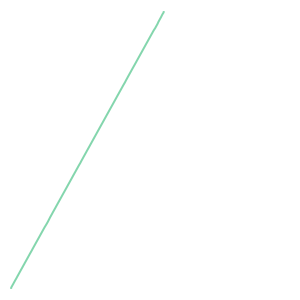

In [338]:
wkt.loads(roads_test.geometry.iloc[0])

In [342]:
roads_test['henge_time'].iloc[10]

"['2025-05-24T20:09:55', '2025-05-25T20:10:46', '2025-05-26T20:11:36', '2025-05-27T20:12:25', '2025-05-28T20:13:13', '2025-05-29T20:14:00', '2025-05-30T20:14:46', '2025-05-31T20:15:30', '2025-06-01T20:16:14', '2025-07-09T20:23:47', '2025-07-10T20:23:21', '2025-07-11T20:22:54', '2025-07-12T20:22:25', '2025-07-13T20:21:53', '2025-07-14T20:21:20', '2025-07-15T20:20:45', '2025-07-16T20:20:08', '2025-07-17T20:19:29']"

In [30]:
roads

,n_sq_vo,c_coinsee,c_desi,c_liaison,l_voie,l_courtmin,l_longmin,c_voie,b_fantoir,b_off,c_voie_vp,objectid,c_domoff,n_sq_co,length,geometry,sinuosity,azimuth,Route_Name,henge_time
0,750003643,75056,AV,DU,DOCTEUR GLEY,Av. du Docteur Gley,Avenue du Docteur Gley,750562834,O,O,2854,6591,P,750001537,None,"LINESTRING (2.40955 48.87791, 2.40987 48.87740...",1.054486,303.625901,Avenue du Docteur Gley,"[2025-05-24T20:31:18, 2025-05-25T20:32:27, 202..."
1,750001741,75056,SQ,None,CLAUDE DEBUSSY,Sq. Claude Debussy,Square Claude Debussy,750562074,O,O,2083,6598,O,750001537,None,"LINESTRING (2.31407 48.88406, 2.31315 48.88474)",1.000000,318.370975,Square Claude Debussy,NaN
2,750001742,75056,RUE,None,CLAUDE GARAMOND,R. Claude Garamond,Rue Claude Garamond,750562075,O,O,2079,6599,P,750001537,None,"LINESTRING (2.30024 48.82585, 2.30050 48.82581...",1.000971,286.488719,Rue Claude Garamond,"[2025-04-16T19:38:48, 2025-04-17T19:40:16, 202..."
3,750003800,75056,RUE,None,CHARLES NODIER,R. Charles Nodier,Rue Charles Nodier,750561866,O,O,1869,6715,P,750001537,None,"LINESTRING (2.34483 48.88445, 2.34487 48.88482...",1.000246,184.762964,Rue Charles Nodier,NaN
4,750001798,75056,AV,DES,CHASSEURS,Av. des Chasseurs,Avenue des Chasseurs,750561910,O,O,1905,6730,P,750001537,None,"LINESTRING (2.30643 48.88741, 2.30614 48.88719...",1.000224,223.262845,Avenue des Chasseurs,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6588,750002964,75056,RUE,D',ORCHAMPT,R. d'Orchampt,Rue d'Orchampt,750566914,O,O,6843,13119,P,750001537,None,"LINESTRING (2.33801 48.88624, 2.33795 48.88629...",1.297154,335.546149,Rue d'Orchampt,NaN
6589,750004662,75056,RUE,DES,ITALIENS,R. des Italiens,Rue des Italiens,750564759,O,O,4688,13143,V,750001537,None,"LINESTRING (2.33595 48.87128, 2.33571 48.87189...",1.354985,189.671199,Rue des Italiens,NaN
6590,750004529,75056,CITE,None,MARTIGNAC,Cité Martignac,Cité Martignac,750566132,O,O,6052,13145,V,750001537,None,"LINESTRING (2.31823 48.85737, 2.31816 48.85722...",1.000000,197.006959,Cité Martignac,NaN
6591,750002900,75056,RUE,None,PIERRE BOURDAN,R. Pierre Bourdan,Rue Pierre Bourdan,750567411,O,O,7372,13150,P,750001537,None,"LINESTRING (2.39212 48.84637, 2.39199 48.84650...",1.009459,325.314125,Rue Pierre Bourdan,NaN
